# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is October 19**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Dar Mortaza Ali**  
**Neptun ID: YLEU5X** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.optim as optim
from torchvision import datasets, models, transforms
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import PIL.Image as Image
import copy
from torch.optim import lr_scheduler
import time
import os
from IPython.display import display
import random

ModuleNotFoundError: No module named 'torchvision'

In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 544.3 kB/s eta 0:00:00m eta 0:00:010:00:03
Note: you may need to restart the kernel to use updated packages.


## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

# import shutil
# shutil.rmtree('/content/cars')

! mkdir ./cars
! mkdir ./cars/test
! mkdir ./cars/train
! kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

def cleanSpaces(word):
  if " " in word:
    nWord = "".join([  letter if letter != " " else  "-" for letter in word ])
    return nWord
  else:
    return word

# pre-select the classes to use
classes_m = ["AM General Hummer SUV 2000", "Acura Integra Type R 2001",
             "Audi TT RS Coupe 2012","BMW X3 SUV 2012", "BMW X5 SUV 2007", "Ferrari FF Coupe 2012",
             "McLaren MP4-12C Coupe 2012","Land Rover LR2 SUV 2012","Lamborghini Aventador Coupe 2012",
             "Jeep Compass SUV 2012","Tesla Model S Sedan 2012","Scion xD Hatchback 2012",
             "Rolls-Royce Phantom Sedan 2012","Porsche Panamera Sedan 2012","Mercedes-Benz Sprinter Van 2012"]

# Unzip only the neccesary classes 
for clas in classes_m:
   s = f'unzip -j "/content/stanford-car-dataset-by-classes-folder.zip" "car_data/car_data/test/{clas}/*" -d "/content/cars/test/{cleanSpaces(clas)}"'
   os.system(s)
   s = f'unzip -j "/content/stanford-car-dataset-by-classes-folder.zip" "car_data/car_data/train/{clas}/*" -d "/content/cars/train/{cleanSpaces(clas)}"'
   os.system(s)
   print(f"Unziped {clas} class")



Saving kaggle.json to kaggle.json
 99% 1.81G/1.83G [00:09<00:00, 281MB/s]
100% 1.83G/1.83G [00:09<00:00, 196MB/s]
Unziped AM General Hummer SUV 2000 class
Unziped Acura Integra Type R 2001 class
Unziped Audi TT RS Coupe 2012 class
Unziped BMW X3 SUV 2012 class
Unziped BMW X5 SUV 2007 class
Unziped Ferrari FF Coupe 2012 class
Unziped McLaren MP4-12C Coupe 2012 class
Unziped Land Rover LR2 SUV 2012 class
Unziped Lamborghini Aventador Coupe 2012 class
Unziped Jeep Compass SUV 2012 class
Unziped Tesla Model S Sedan 2012 class
Unziped Scion xD Hatchback 2012 class
Unziped Rolls-Royce Phantom Sedan 2012 class
Unziped Porsche Panamera Sedan 2012 class
Unziped Mercedes-Benz Sprinter Van 2012 class


In [3]:
train_dir = "cars/train"
test_dir = "cars/test"


In [57]:

train_trans =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

#### Splitting the dataset

In [77]:
train_data = torchvision.datasets.ImageFolder(train_dir, transform = train_trans)
test_data = torchvision.datasets.ImageFolder(test_dir, transform = test_trans)

In [78]:
n_test_samples = int(len(test_data) * 0.6)
n_valid_samples = len(test_data) - n_test_samples

test_data, valid_data = torch.utils.data.random_split(test_data,
                                           [n_test_samples, n_valid_samples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = val_trans

In [79]:
#Load
BATCH_SIZE = 4
num_work = 2
train_load = torch.utils.data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_load = torch.utils.data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_load = torch.utils.data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)
dataload = {'train': torch.utils.data.DataLoader(train_load, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_work) ,
               'val': torch.utils.data.DataLoader(valid_load, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_work)}


#### Pre-processing the dataset

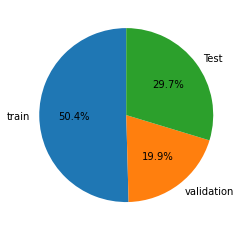

In [80]:
labels = 'train', 'validation', 'Test'
sizes = [len(train_data), len(valid_data), len(test_data)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
plt.show()

In [81]:
print("Training set: ",len(train_data))
print("valid set:", len(valid_data))
print("Test set:", len(test_data))
print('Number of classes: '+str(len(train_data.classes)))

Training set:  637
valid set: 251
Test set: 375
Number of classes: 15


McLaren-MP4-12C-Coupe-2012 -- Audi-TT-RS-Coupe-2012 -- McLaren-MP4-12C-Coupe-2012 -- BMW-X5-SUV-2007


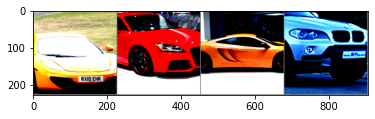

In [82]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()

print(' -- '.join('%5s' % train_data.classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [83]:
import warnings
warnings.filterwarnings('ignore')
model = models.alexnet(pretrained=True)



In [84]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(classes_m))



#### Define your optimizer and loss function

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
schedulr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


cuda:0


In [86]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Train your network

In [87]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1
            print(f'Early Stop Counter: {self.num_bad_epochs}')

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [88]:
early_stopping = EarlyStopping()

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    es = EarlyStopping(patience=patience)
    terminate_training = False
    for epoch in range(num_epochs): 
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            datasett = [valid_load if phase == 'val' else ([train_load if phase == 'train' else test_load][0])][0]
            for inputs, labels in datasett:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasett.dataset)
            epoch_acc = 100 * running_corrects.double() / len(datasett.dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Save the information for the graph
            if phase == "train":
              train_loss.append(float("{0:.4f}".format(epoch_loss)))
              train_acc.append(float("{0:.4f}".format(epoch_acc)))
            elif phase == "test":
              test_loss.append(float("{0:.4f}".format(epoch_loss)))
              test_acc.append(float("{0:.4f}".format(epoch_acc)))

            # Early stop
            if phase == 'val' and es.step(epoch_loss):
                terminate_training = True
                print('early stop criterion is met, we can stop now')

            # deep copy the model
            if (phase == 'test' and epoch_acc > best_acc) or (terminate_training): 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                if terminate_training:
                  break

        print()

    # time_elapsed = time.time() - since
    print('Training complete')
    print('Best Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # display graph
    accuracies = {"train_acc" : train_acc, "test_acc": test_acc, "train_loss" : train_loss, "test_loss": test_loss }

    return model, accuracies

In [90]:
model, accuracies = train_model(model, criterion, optimizer,
                         schedulr, num_epochs=20)

Epoch 1/20
----------
train Loss: 3.6992 Acc: 29.8273
test Loss: 3.6925 Acc: 40.2667
val Loss: 3.5530 Acc: 47.4104

Epoch 2/20
----------
train Loss: 3.3898 Acc: 44.2700
test Loss: 3.2899 Acc: 46.9333
val Loss: 2.8299 Acc: 52.1912

Epoch 3/20
----------
train Loss: 3.1598 Acc: 49.2936
test Loss: 2.9122 Acc: 51.2000
val Loss: 2.6357 Acc: 56.1753

Epoch 4/20
----------
train Loss: 3.2138 Acc: 53.2182
test Loss: 2.6189 Acc: 54.9333
val Loss: 2.6596 Acc: 61.3546
Early Stop Counter: 1

Epoch 5/20
----------
train Loss: 2.5869 Acc: 57.9278
test Loss: 2.7829 Acc: 55.2000
val Loss: 2.6360 Acc: 60.9562
Early Stop Counter: 2

Epoch 6/20
----------
train Loss: 2.5508 Acc: 55.1020
test Loss: 2.8696 Acc: 53.6000
val Loss: 3.5773 Acc: 50.1992
Early Stop Counter: 3

Epoch 7/20
----------
train Loss: 2.3718 Acc: 61.2245
test Loss: 2.4834 Acc: 58.9333
val Loss: 3.1112 Acc: 57.3705
Early Stop Counter: 4

Epoch 8/20
----------
train Loss: 1.8336 Acc: 66.2480
test Loss: 2.0449 Acc: 65.0667
val Loss: 2.260

#### Show results (accuracy and loss) on training and validation sets

In [91]:
def results():
  fig = plt.figure(figsize=(10,5))
  plt.title("Train and Test Accuracy")
  plt.plot(accuracies["train_acc"], label='train accuracy')
  plt.plot(accuracies["test_acc"], label='test accuracy')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('accuracy', fontsize=12)
  plt.legend(loc='best')
  plt.show()

  # Loss  graph
  fig = plt.figure(figsize=(10,5))
  plt.title("Train and Test Loss")
  plt.plot(accuracies["train_loss"], label='train loss')
  plt.plot(accuracies["test_loss"], label='test loss')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('accuracy', fontsize=12)
  plt.legend(loc='best')
  plt.show()

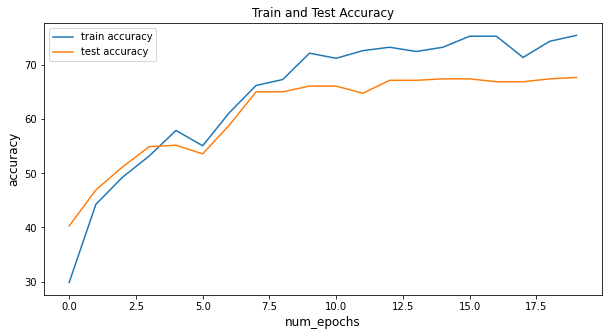

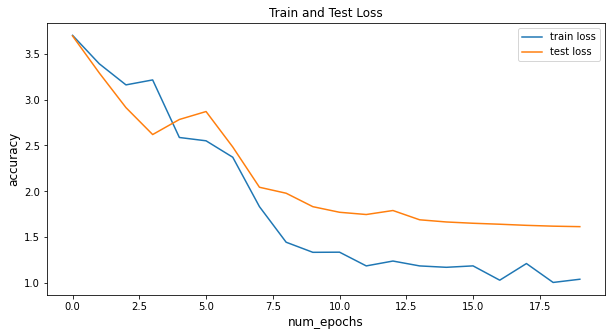

In [92]:
results()

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [93]:
def eval():
  correct_predictions = 0
  total_pred = 0
  with torch.no_grad():
      for inputs, labels in test_load:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total_pred += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()
  print('Accuracy of the CNN with test inputs: %d %%' % (100 * correct_predictions / total_pred))

In [94]:
eval()

Accuracy of the CNN with test inputs: 67 %


#### Show some predictions

Real-Data  Audi-TT-RS-Coupe-2012 -- Mercedes-Benz-Sprinter-Van-2012 -- AM-General-Hummer-SUV-2000 -- Porsche-Panamera-Sedan-2012


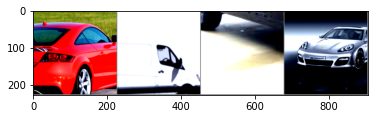

Predicted:  Audi-TT-RS-Coupe-2012 -- Mercedes-Benz-Sprinter-Van-2012 -- Tesla-Model-S-Sedan-2012 -- Porsche-Panamera-Sedan-2012


In [95]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()
# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()
print('Real-Data ',' -- '.join('%5s' % train_data.classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' -- '.join('%5s' % train_data.classes[predicted[j]]
                              for j in range(4)))

#### Answer the questions

##We can see that the model has a very low accuracy in the beginning but it improves significantly with just a few epochs
##The model is neither overfitting nor underfitting as we can see from the plot that the accuracies of the train and valid set are almost the same